In [14]:
import requests

requests.get('http://www.google.com', timeout=10).ok

True

In [15]:
%%capture

!pip install --upgrade kaggle-environments

In [16]:
from kaggle_environments import make
env = make("chess", debug=True)


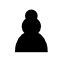
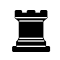
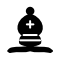
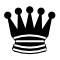
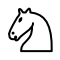
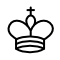
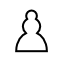
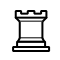
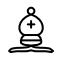
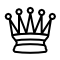
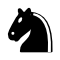
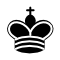

In [17]:
result = env.run(['random', 'random'])
env.render(mode='ipython', width=1000, height=1000)

In [18]:
%%writefile main.py

from Chessnut import Game
import random

def chessbot(obs):
    game = Game(obs.board)
    moves = list(game.get_moves())

    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    for move in moves[:10]:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move

    for move in moves[:10]:
        if "q" in move.lower():
            return move

    return random.choice(moves)

Overwriting main.py


Agent exit status/reward/time left: 
	 DONE / 1 / 9.776073000000002
	 DONE / 0 / 10





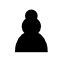
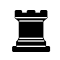
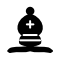
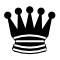
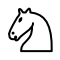
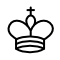
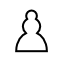
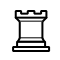
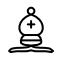
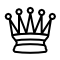
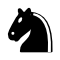
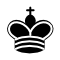

In [19]:
result = env.run(['main.py', 'random'])
print('Agent exit status/reward/time left: ')

for agent in result[-1]:
    print('\t', agent.status, '/', agent.reward, '/', agent.observation.remainingOverageTime)
print('\n')

env.render(mode='ipython', width=1000, height=1000)